In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../..')
from viz.goals_origin import plot_goals_origin
from viz.assisted_goals import plot_assisted_goals
from viz.assist_passes import plot_assist_passes
from viz.dribbles_heatmap import plot_dribbles_heatmap
from viz.impact_timeline import plot_impact_timeline
from viz.progression_xthreat import plot_progression_xthreat
from viz.box_entries import plot_box_entries

# Crear directorios de salida si no existen
os.makedirs('./outputs', exist_ok=True)
os.makedirs('./outputs/plots', exist_ok=True)

In [2]:
DATA_DIR = './data'

match_folders = sorted([f for f in os.listdir(DATA_DIR) 
                       if os.path.isdir(os.path.join(DATA_DIR, f))])

print(f"Partidos encontrados: {len(match_folders)}")

Partidos encontrados: 38


In [3]:
def load_all_events():
    all_events = []
    
    for folder in match_folders:
        folder_path = os.path.join(DATA_DIR, folder)
        match_date = folder.split('_')[0]
        
        try:
            df = pd.read_csv(os.path.join(folder_path, 'match_events.csv'))
            df['match_folder'] = folder
            df['match_date'] = match_date
            all_events.append(df)
        except Exception as e:
            print(f"Error en {folder}: {e}")
    
    return pd.concat(all_events, ignore_index=True)

print("Cargando eventos...")
df_events = load_all_events()
df_messi = df_events[df_events['player'] == 'Lionel Messi'].copy()

print(f"Total eventos: {len(df_events):,}")
print(f"Eventos de Messi: {len(df_messi):,}")

Cargando eventos...
Total eventos: 72,761
Eventos de Messi: 2,814


In [4]:
# NUEVA LOGICA: Desde los goles hacia atrás
all_goals = df_events[df_events.get('is_goal', False) == True].copy()
print(f"Total goles en todos los partidos: {len(all_goals)}")

# Goles de Messi
goals_messi = all_goals[all_goals['player'] == 'Lionel Messi'].copy()
print(f"Goles de Messi: {len(goals_messi)}")

Total goles en todos los partidos: 154
Goles de Messi: 32


In [5]:
def classify_goal_origin_messi(goal_idx, df_events):
    """
    Clasifica origen del gol de Messi mirando evento INMEDIATAMENTE anterior (e-1).
    
    Regla:
    - e-1 = TakeOn exitoso de Messi → "Regate previo"
    - e-1 = Carry de Messi → "Carry individual"
    - e-1 = Pass/Carry de OTRO jugador → "Asistido"
    - e-1 = Otro/Sin eventos → "Rebote"
    """
    goal_event = df_events.loc[goal_idx]
    team = goal_event['team']
    possession_id = goal_event.get('possession_id')

    # Buscar eventos anteriores en la misma posesión
    prev_events = df_events[
        (df_events.index < goal_idx) &
        (df_events['team'] == team) &
        (df_events['possession_id'] == possession_id)
    ].tail(10)

    if len(prev_events) == 0:
        return 'Rebote'

    # Evento INMEDIATAMENTE anterior (e-1)
    last_event = prev_events.iloc[-1]

    # ¿Es de Messi?
    if last_event['player'] == 'Lionel Messi':
        # Clasificar según tipo de evento
        if last_event['event_type'] == 'TakeOn' and last_event.get('outcome_type') == 'Successful':
            return 'Regate previo'
        elif last_event['event_type'] == 'Carry':
            return 'Carry individual'
        else:
            # Otro tipo de evento de Messi (toque, recuperación, etc.)
            return 'Rebote'
    else:
        # Evento anterior es de OTRO jugador
        if last_event['event_type'] in ['Pass', 'Carry']:
            return 'Asistido'
        else:
            return 'Rebote'

# Clasificar goles de Messi
goals_messi['origin_type'] = goals_messi.index.map(
    lambda idx: classify_goal_origin_messi(idx, df_events)
)

print(f"\nClasificación de goles de Messi:")
print(goals_messi['origin_type'].value_counts())


Clasificación de goles de Messi:
origin_type
Asistido         23
Rebote            6
Regate previo     3
Name: count, dtype: int64


In [6]:
dribbles_messi = df_messi[df_messi['event_type'] == 'TakeOn'].copy()
print(f"Regates: {len(dribbles_messi)}")
print(f"Exitosos: {(dribbles_messi['outcome_type'] == 'Successful').sum()}")

Regates: 209
Exitosos: 97


In [7]:
def get_messi_assists(all_goals, df_events):
    """
    Obtiene asistencias de Messi buscando el ÚLTIMO Pass antes de cada gol.
    
    Regla:
    - Buscar ÚLTIMO Pass en la posesión antes del gol
    - Si ese Pass es de Messi → ASISTENCIA
    - Carry/TakeOn NO interrumpen (solo otro Pass)
    """
    assisted_goals = []
    assist_passes = []
    
    for goal_idx in all_goals.index:
        goal = all_goals.loc[goal_idx]
        team = goal['team']
        possession_id = goal.get('possession_id')
        
        # Buscar eventos anteriores en la misma posesión
        prev_events = df_events[
            (df_events.index < goal_idx) &
            (df_events['team'] == team) &
            (df_events['possession_id'] == possession_id)
        ].tail(10)
        
        if len(prev_events) == 0:
            continue
        
        # Buscar ÚLTIMO Pass antes del gol
        passes = prev_events[prev_events['event_type'] == 'Pass']
        
        if len(passes) == 0:
            continue  # No hay pases antes del gol
        
        # Último Pass antes del gol
        last_pass = passes.iloc[-1]
        
        # ¿Es de Messi?
        if last_pass['player'] == 'Lionel Messi':
            # ASISTENCIA CONFIRMADA
            assisted_goal = {
                'x_assist': last_pass['x'],
                'y_assist': last_pass['y'],
                'x_shot': goal['x'],
                'y_shot': goal['y'],
                'xg': goal.get('xg', 0.1),
                'is_goal': True,
                'body_part': goal.get('shot_body_part', 'Foot'),
                'shooter': goal.get('player', 'Unknown')
            }
            assisted_goals.append(assisted_goal)
            
            # Pase de asistencia
            assist_pass = {
                'x': last_pass['x'],
                'y': last_pass['y'],
                'end_x': goal['x'],
                'end_y': goal['y'],
                'xg': goal.get('xg', 0.1),
                'pass_length': last_pass.get('pass_distance', 
                                             np.sqrt((goal['x'] - last_pass['x'])**2 + 
                                                   (goal['y'] - last_pass['y'])**2)),
                'receiver': goal.get('player', 'Unknown'),
                'pass_outcome': 'Goal'
            }
            assist_passes.append(assist_pass)
    
    print(f"Total goles en todos los partidos: {len(all_goals)}")
    print(f"Asistencias de Messi (último Pass antes del gol): {len(assisted_goals)}")
    
    return pd.DataFrame(assisted_goals), pd.DataFrame(assist_passes)

assisted_goals, assist_passes = get_messi_assists(all_goals, df_events)
assisted_goals.to_csv('./outputs/messi_assisted_goals.csv', index=False)
print(f"\nGoles asistidos guardados: {len(assisted_goals)}")

Total goles en todos los partidos: 154
Asistencias de Messi (último Pass antes del gol): 25

Goles asistidos guardados: 25


In [8]:
assist_passes.to_csv('./outputs/messi_assists.csv', index=False)
goals_messi.to_csv('./outputs/messi_goals.csv', index=False)
dribbles_messi.to_csv('./outputs/messi_dribbles.csv', index=False)

print("CSVs guardados:")
print(f"  - Goles de Messi: {len(goals_messi)}")
print(f"  - Asistencias: {len(assist_passes)}")
print(f"  - Regates: {len(dribbles_messi)}")

CSVs guardados:
  - Goles de Messi: 32
  - Asistencias: 25
  - Regates: 209


In [9]:
# Preparar datos para Timeline de Impacto
def prepare_impact_timeline(df_messi, goals_messi, assist_passes):
    """Prepara eventos decisivos para timeline con contexto de marcador real POR PARTIDO."""
    timeline_events = []
    
    def get_score_context(minute, team, match_folder):
        """Calcula el contexto del marcador en un minuto dado EN UN PARTIDO ESPECÍFICO."""
        # Filtrar goles solo de este partido
        match_goals = df_events[
            (df_events['match_folder'] == match_folder) &
            (df_events.get('is_goal', False) == True)
        ].copy()
        
        # Contar goles antes de este minuto
        goals_before = match_goals[match_goals['minute'] < minute]
        
        team_goals = len(goals_before[goals_before['team'] == team])
        opponent_goals = len(goals_before[goals_before['team'] != team])
        
        if team_goals > opponent_goals:
            return 'winning'
        elif team_goals < opponent_goals:
            return 'losing'
        else:
            return 'drawing'
    
    messi_team = df_messi.iloc[0]['team'] if len(df_messi) > 0 else None
    
    # Goles de Messi
    for _, goal in goals_messi.iterrows():
        minute = goal.get('minute', 0)
        match_folder = goal.get('match_folder', '')
        timeline_events.append({
            'minute': minute,
            'event_type': 'goal',
            'score_context': get_score_context(minute, messi_team, match_folder),
            'description': f"Goal (xG: {goal.get('xg', 0):.2f})"
        })
    
    # Asistencias de Messi
    for _, assist in assist_passes.iterrows():
        goal_events = df_events[
            (df_events['x'] == assist['end_x']) &
            (df_events['y'] == assist['end_y']) &
            (df_events.get('is_goal', False) == True)
        ]
        if len(goal_events) > 0:
            goal_event = goal_events.iloc[0]
            minute = goal_event.get('minute', 0)
            match_folder = goal_event.get('match_folder', '')
            timeline_events.append({
                'minute': minute,
                'event_type': 'assist',
                'score_context': get_score_context(minute, messi_team, match_folder),
                'description': f"Assist to {assist['receiver']}"
            })
    
    # Pases clave (xG > 0.15)
    key_passes = df_messi[
        (df_messi['event_type'] == 'Pass') &
        (df_messi.get('is_assist', False) == False)
    ]
    
    for _, pass_event in key_passes.iterrows():
        next_events = df_events[
            (df_events.index > pass_event.name) &
            (df_events['team'] == pass_event['team']) &
            (df_events['possession_id'] == pass_event.get('possession_id'))
        ].head(3)
        
        for _, next_ev in next_events.iterrows():
            if next_ev.get('is_shot', False):
                xg = next_ev.get('xg', 0)
                if xg > 0.15 and not next_ev.get('is_goal', False):
                    minute = pass_event.get('minute', 0)
                    match_folder = pass_event.get('match_folder', '')
                    timeline_events.append({
                        'minute': minute,
                        'event_type': 'key_pass',
                        'score_context': get_score_context(minute, messi_team, match_folder),
                        'description': f"Key pass (xG: {xg:.2f})"
                    })
                    break
    
    # Regates que llevan a shot
    dribbles = df_messi[
        (df_messi['event_type'] == 'TakeOn') &
        (df_messi.get('outcome_type') == 'Successful')
    ]
    
    for _, dribble in dribbles.iterrows():
        next_events = df_events[
            (df_events.index > dribble.name) &
            (df_events['team'] == dribble['team']) &
            (df_events['possession_id'] == dribble.get('possession_id'))
        ].head(3)
        
        if any(next_events.get('is_shot', False)):
            minute = dribble.get('minute', 0)
            match_folder = dribble.get('match_folder', '')
            timeline_events.append({
                'minute': minute,
                'event_type': 'dribble_to_shot',
                'score_context': get_score_context(minute, messi_team, match_folder),
                'description': "Dribble → Shot"
            })
    
    timeline_df = pd.DataFrame(timeline_events)
    timeline_df = timeline_df.sort_values('minute').reset_index(drop=True)
    return timeline_df

timeline_data = prepare_impact_timeline(df_messi, goals_messi, assist_passes)
timeline_data.to_csv('./outputs/messi_timeline.csv', index=False)
print(f"Timeline events: {len(timeline_data)}")
print(timeline_data['event_type'].value_counts())
print("\nContexto de marcador:")
print(timeline_data['score_context'].value_counts())

Timeline events: 150
event_type
dribble_to_shot    93
goal               32
assist             25
Name: count, dtype: int64

Contexto de marcador:
score_context
winning    70
drawing    53
losing     27
Name: count, dtype: int64


In [10]:
# Preparar datos para Progresión y xThreat
def prepare_progression_xthreat(df_messi):
    """Prepara carries y passes progresivos con xThreat."""
    progression_actions = []
    
    # Carries progresivos
    carries = df_messi[df_messi['event_type'] == 'Carry'].copy()
    for _, carry in carries.iterrows():
        if pd.notna(carry.get('x')) and pd.notna(carry.get('end_x')):
            delta_x = carry['end_x'] - carry['x']
            if delta_x > 5:
                progression_actions.append({
                    'x': carry['x'],
                    'y': carry['y'],
                    'end_x': carry['end_x'],
                    'end_y': carry['end_y'],
                    'xthreat': carry.get('xthreat_gen', 0),
                    'action_type': 'carry'
                })
    
    # Passes progresivos
    passes = df_messi[
        (df_messi['event_type'] == 'Pass') &
        (df_messi.get('is_progressive', False) == True)
    ].copy()
    
    for _, pass_ev in passes.iterrows():
        if pd.notna(pass_ev.get('x')) and pd.notna(pass_ev.get('end_x')):
            progression_actions.append({
                'x': pass_ev['x'],
                'y': pass_ev['y'],
                'end_x': pass_ev['end_x'],
                'end_y': pass_ev['end_y'],
                'xthreat': pass_ev.get('xthreat_gen', 0),
                'action_type': 'pass'
            })
    
    return pd.DataFrame(progression_actions)

progression_data = prepare_progression_xthreat(df_messi)
progression_data.to_csv('./outputs/messi_progression.csv', index=False)
print(f"Progression actions: {len(progression_data)}")
print(f"  Carries: {len(progression_data[progression_data['action_type'] == 'carry'])}")
print(f"  Progressive passes: {len(progression_data[progression_data['action_type'] == 'pass'])}")
print(f"  Total xThreat: {progression_data['xthreat'].sum():.3f}")

Progression actions: 431
  Carries: 131
  Progressive passes: 300
  Total xThreat: 11.514


In [11]:
# Preparar datos para Box Entries
def prepare_box_entries(df_messi):
    """Prepara entradas al área con tipo y resultado CORRECTO."""
    box_entries = []
    
    # Buscar eventos que entran al área
    entries = df_messi[df_messi.get('is_box_entry', False) == True].copy()
    
    for _, entry in entries.iterrows():
        if pd.notna(entry.get('x')) and pd.notna(entry.get('end_x')):
            # Determinar tipo de entrada
            entry_type = 'Pass'
            if entry['event_type'] == 'Carry':
                entry_type = 'Carry'
            elif entry['event_type'] == 'TakeOn':
                entry_type = 'Dribble'
            
            # Determinar resultado (buscar próximos eventos SOLO DEL MISMO EQUIPO)
            next_events = df_events[
                (df_events.index > entry.name) &
                (df_events['team'] == entry['team']) &
                (df_events['possession_id'] == entry.get('possession_id'))
            ].head(5)
            
            outcome = 'nothing'
            if len(next_events) > 0:
                # Buscar shot o assist (en orden)
                for _, next_ev in next_events.iterrows():
                    # Si hay shot, es outcome = 'shot'
                    if next_ev.get('is_shot', False):
                        outcome = 'shot'
                        break
                    # Si Messi asiste (Pass que lleva a gol), es outcome = 'assist'
                    elif next_ev['event_type'] == 'Pass' and next_ev['player'] == 'Lionel Messi':
                        # Buscar si este pase lleva a gol
                        next_next = df_events[
                            (df_events.index > next_ev.name) &
                            (df_events['team'] == next_ev['team']) &
                            (df_events['possession_id'] == next_ev.get('possession_id'))
                        ].head(2)
                        if any(next_next.get('is_goal', False)):
                            outcome = 'assist'
                            break
            
            box_entries.append({
                'x': entry['x'],
                'y': entry['y'],
                'entry_x': entry['end_x'],
                'entry_y': entry['end_y'],
                'entry_type': entry_type,
                'outcome': outcome
            })
    
    return pd.DataFrame(box_entries)

box_entries_data = prepare_box_entries(df_messi)
box_entries_data.to_csv('./outputs/messi_box_entries.csv', index=False)
print(f"Box entries: {len(box_entries_data)}")
print(f"  By type: {box_entries_data['entry_type'].value_counts().to_dict()}")
print(f"  By outcome: {box_entries_data['outcome'].value_counts().to_dict()}")

Box entries: 177
  By type: {'Pass': 143, 'Carry': 34}
  By outcome: {'shot': 177}


Viz 1: Goals by Origin - Guardado


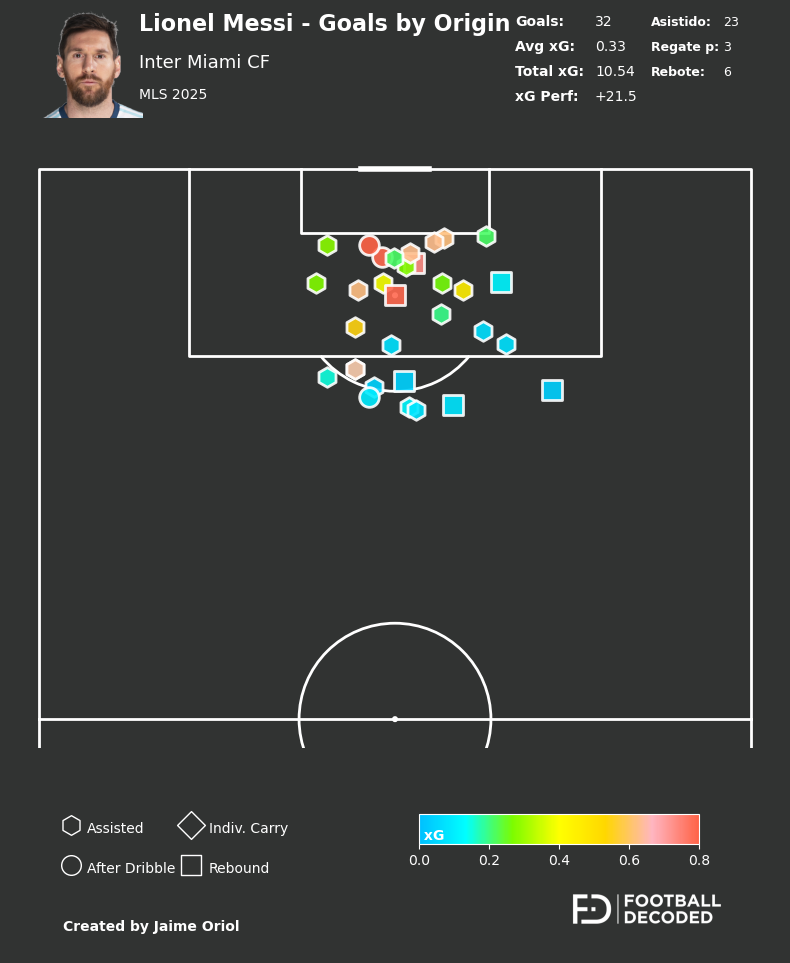

In [12]:
# Viz 1: Goals by Origin
fig1 = plot_goals_origin(
    csv_path='./outputs/messi_goals.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/01_goals_origin.png'
)
print("Viz 1: Goals by Origin - Guardado")

Viz 2: Assisted Goals - Guardado


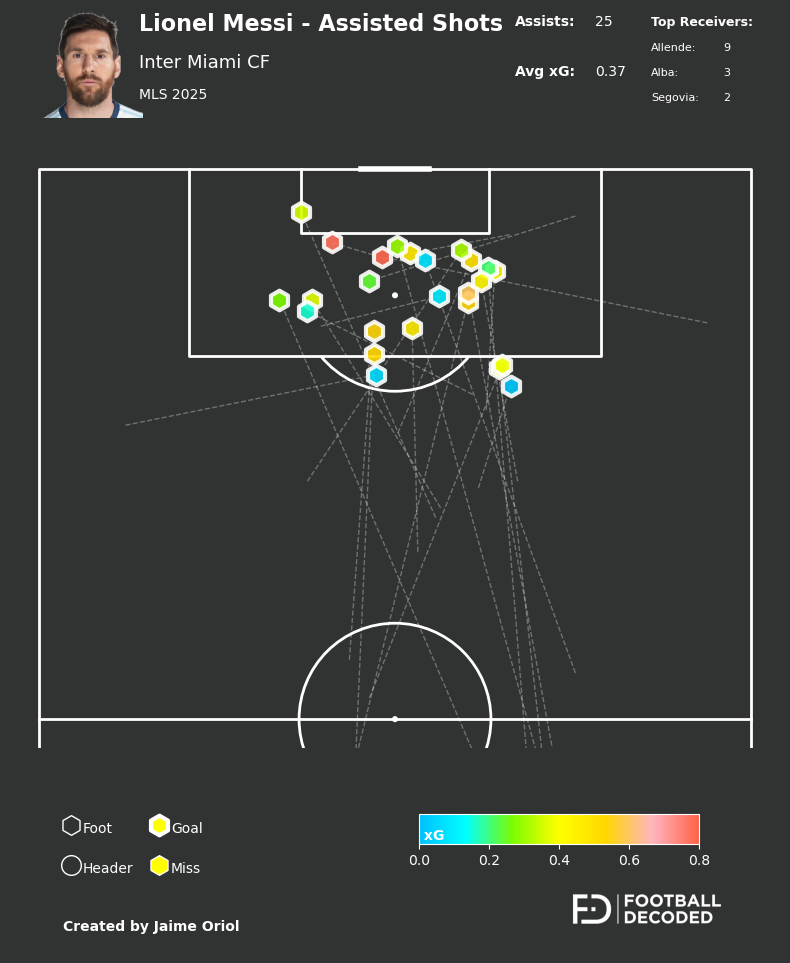

In [13]:
# Viz 2: Assisted Goals
fig2 = plot_assisted_goals(
    csv_path='./outputs/messi_assisted_goals.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/02_assisted_goals.png'
)
print("Viz 2: Assisted Goals - Guardado")

Viz 3: Assist Passes - Guardado


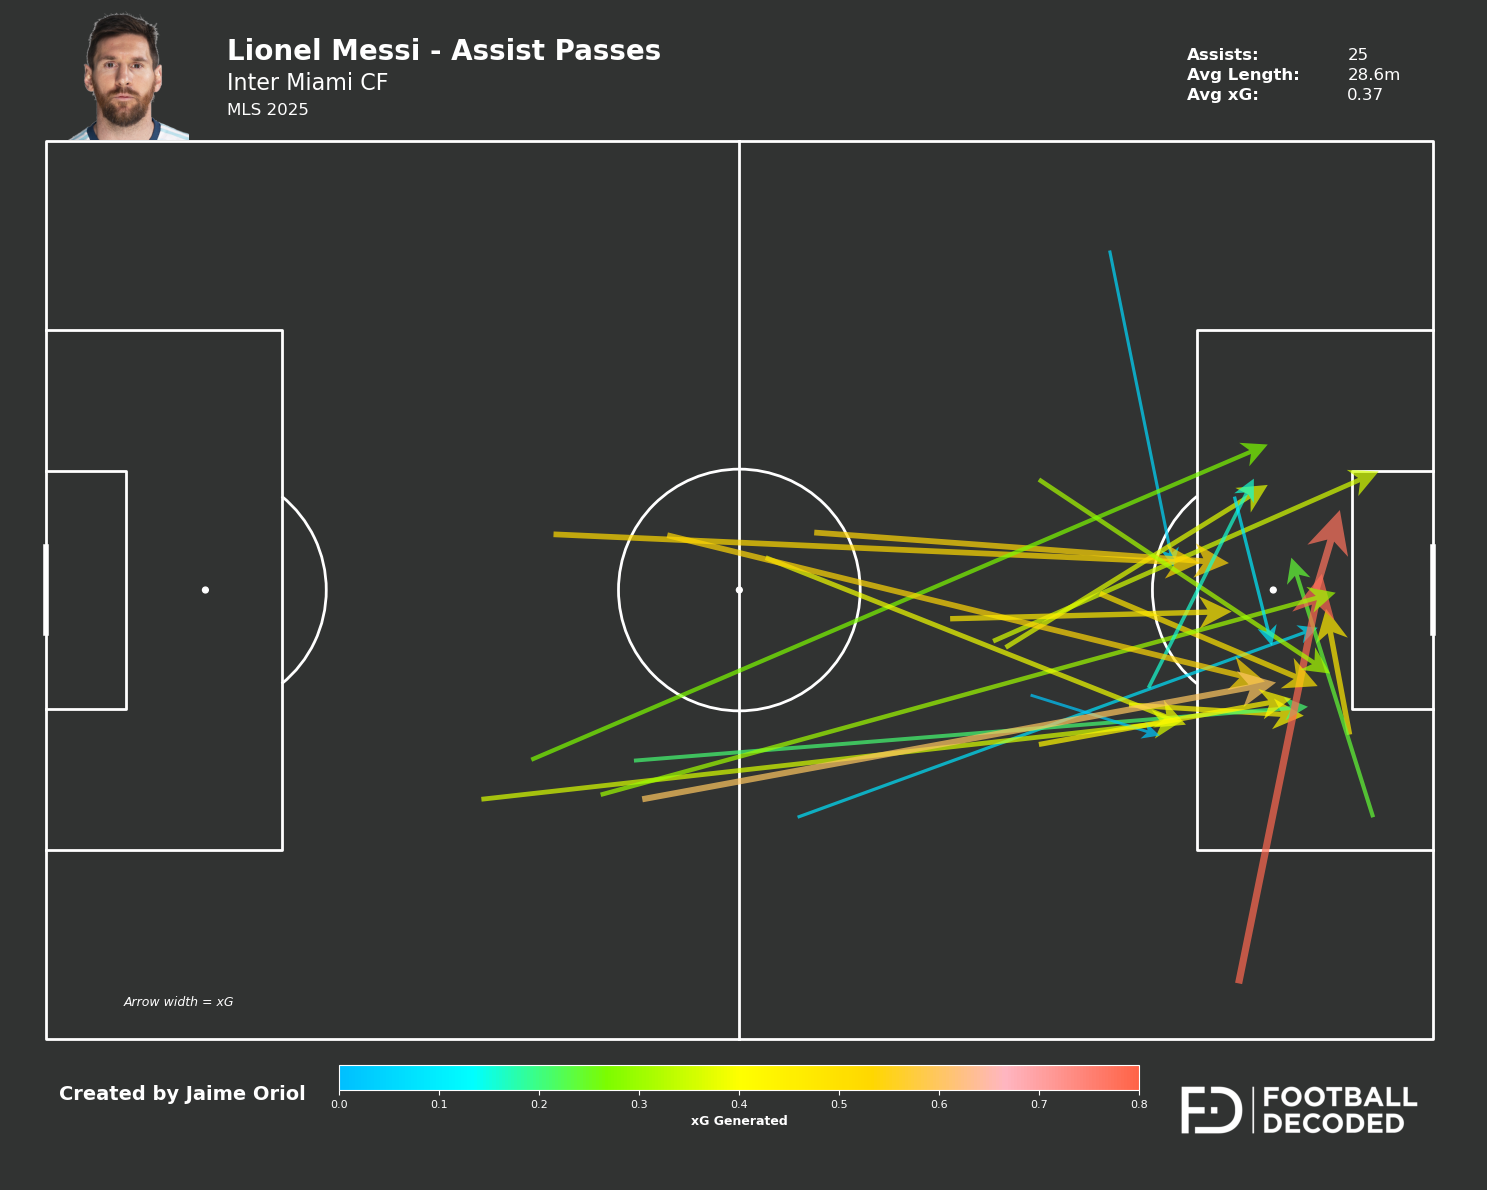

In [14]:
# Viz 3: Assist Passes
fig3 = plot_assist_passes(
    csv_path='./outputs/messi_assists.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/03_assist_passes.png'
)
print("Viz 3: Assist Passes - Guardado")

Viz 4: Dribbles Heatmap - Guardado


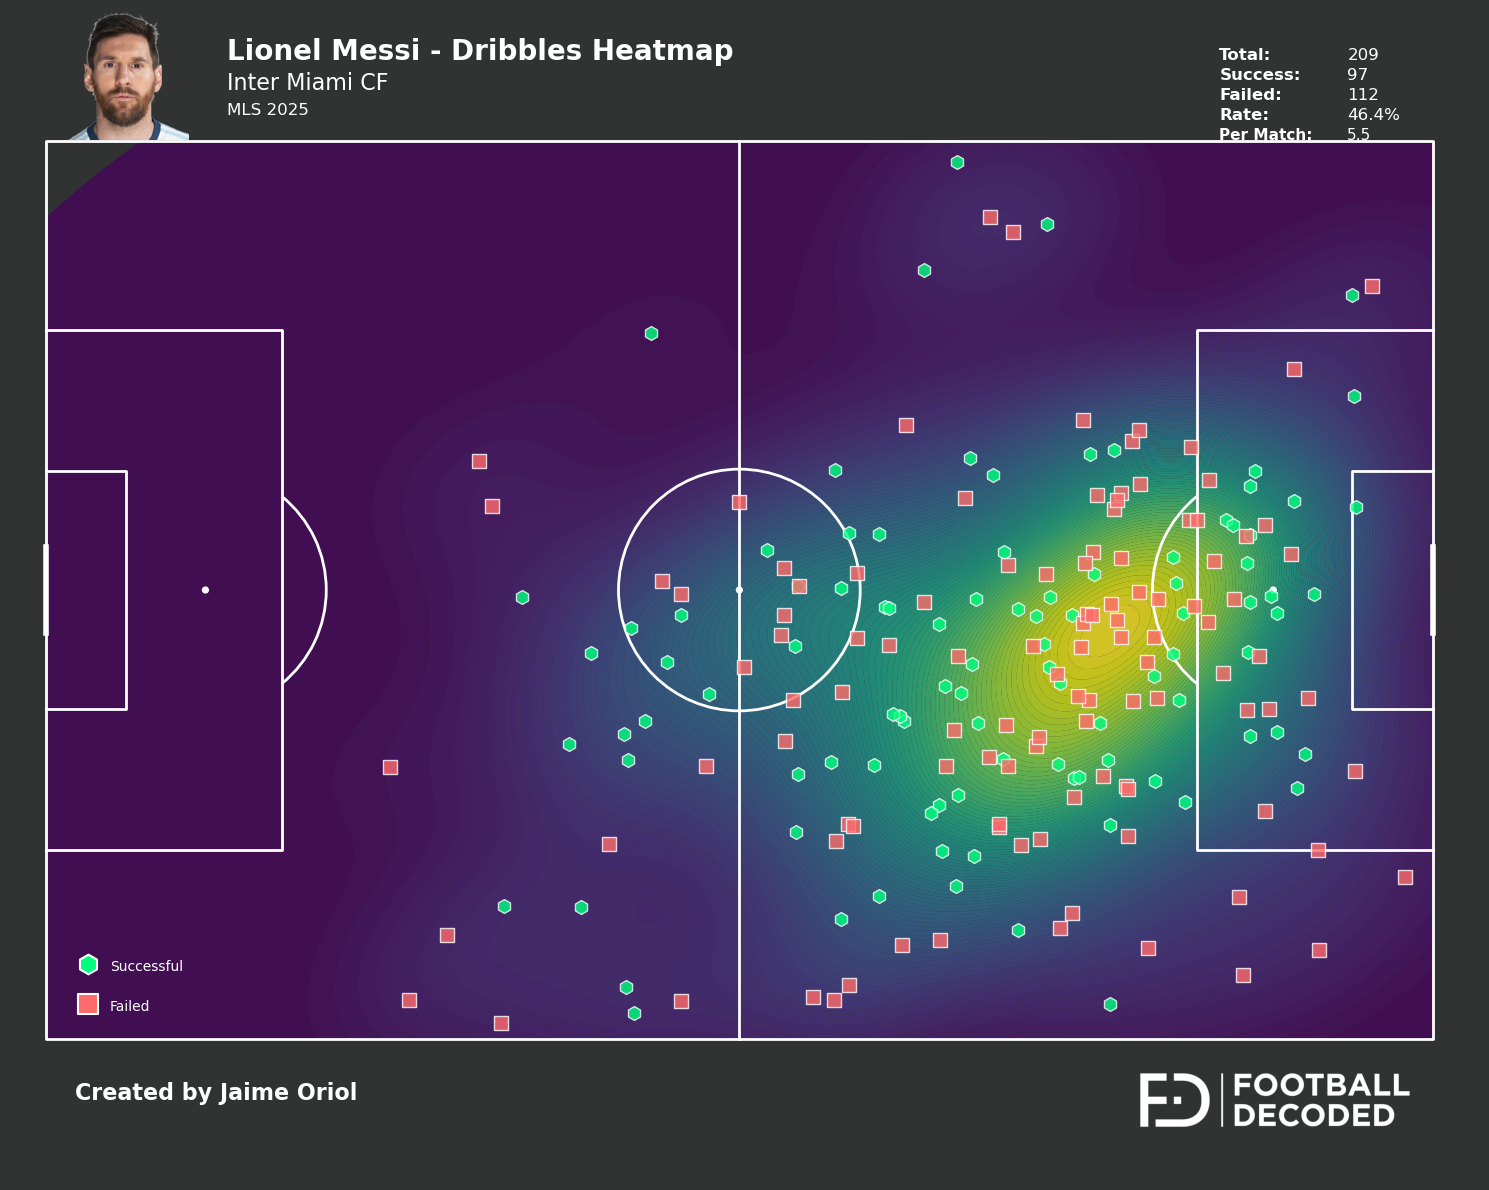

In [15]:
# Viz 4: Dribbles Heatmap
fig4 = plot_dribbles_heatmap(
    csv_path='./outputs/messi_dribbles.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    match_count=38,
    save_path='./outputs/plots/04_dribbles_heatmap.png'
)
print("Viz 4: Dribbles Heatmap - Guardado")

Viz 5: Impact Timeline - Guardado


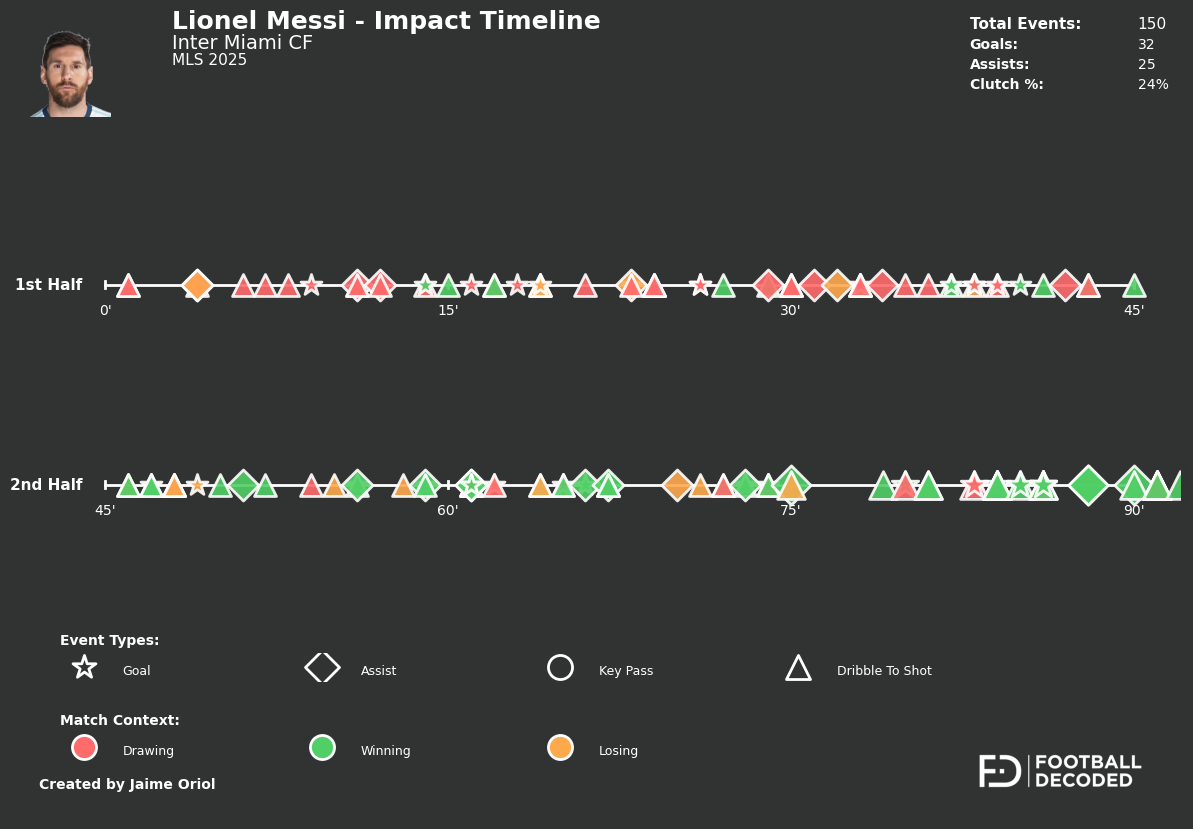

In [16]:
# Viz 5: Impact Timeline
fig5 = plot_impact_timeline(
    csv_path='./outputs/messi_timeline.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/05_impact_timeline.png'
)
print("Viz 5: Impact Timeline - Guardado")

Viz 6: Progression & xThreat - Guardado


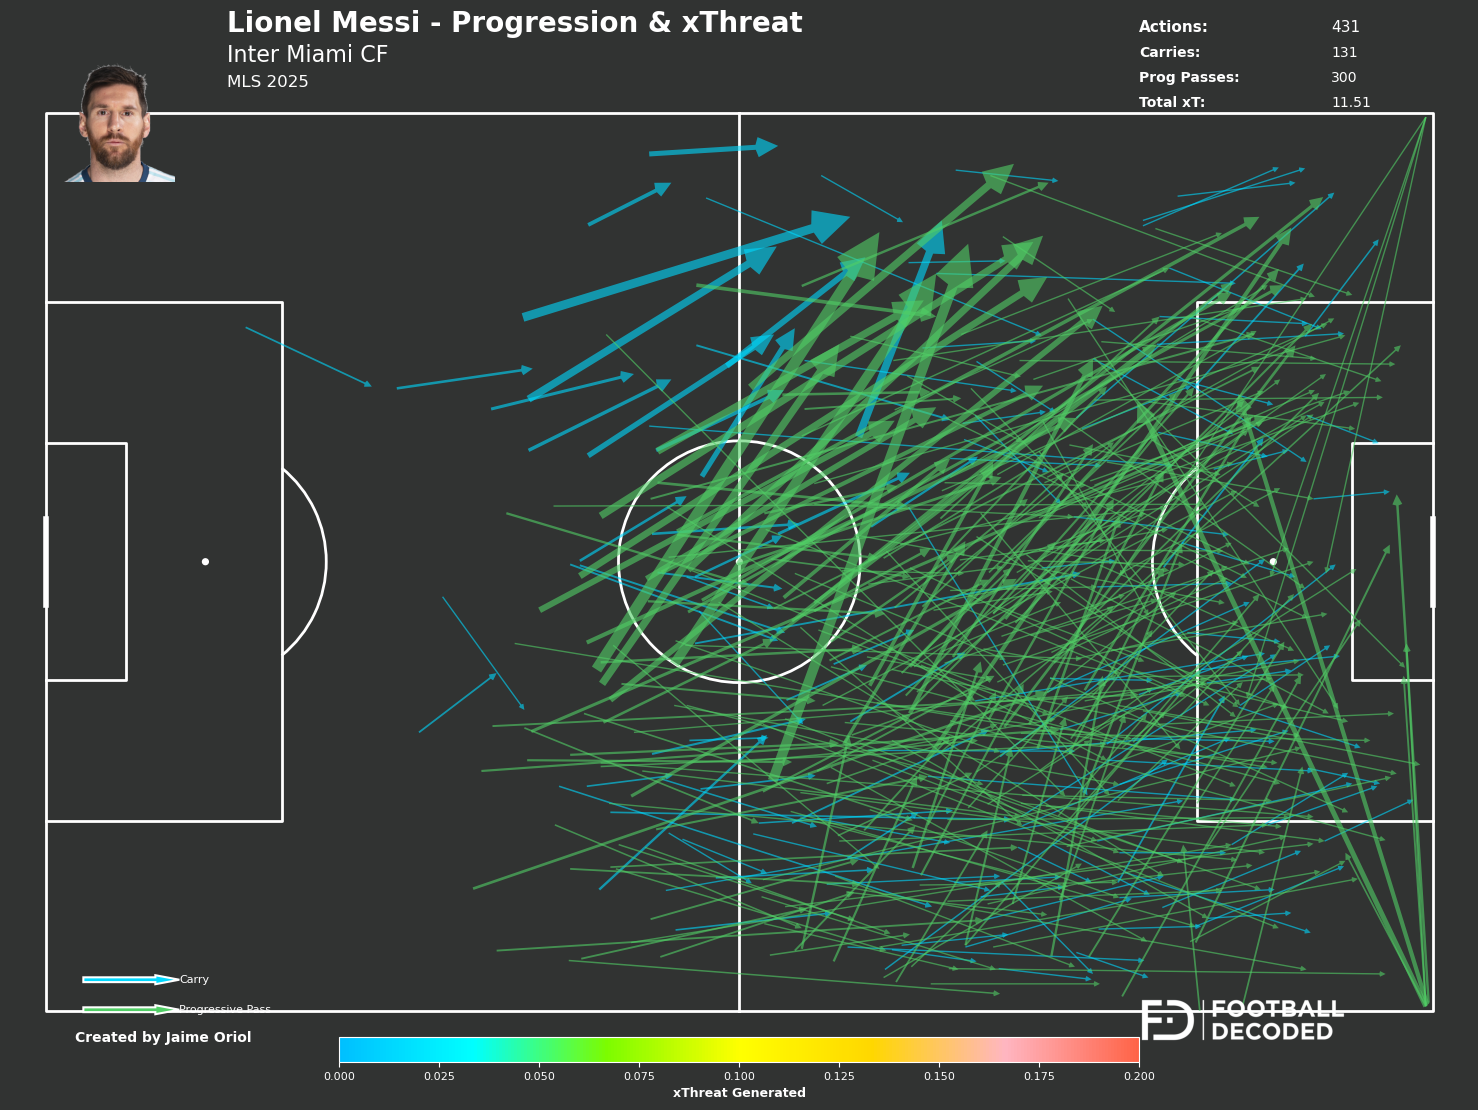

In [17]:
# Viz 6: Progression & xThreat
fig6 = plot_progression_xthreat(
    csv_path='./outputs/messi_progression.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/06_progression_xthreat.png'
)
print("Viz 6: Progression & xThreat - Guardado")

Viz 7: Box Entries - Guardado


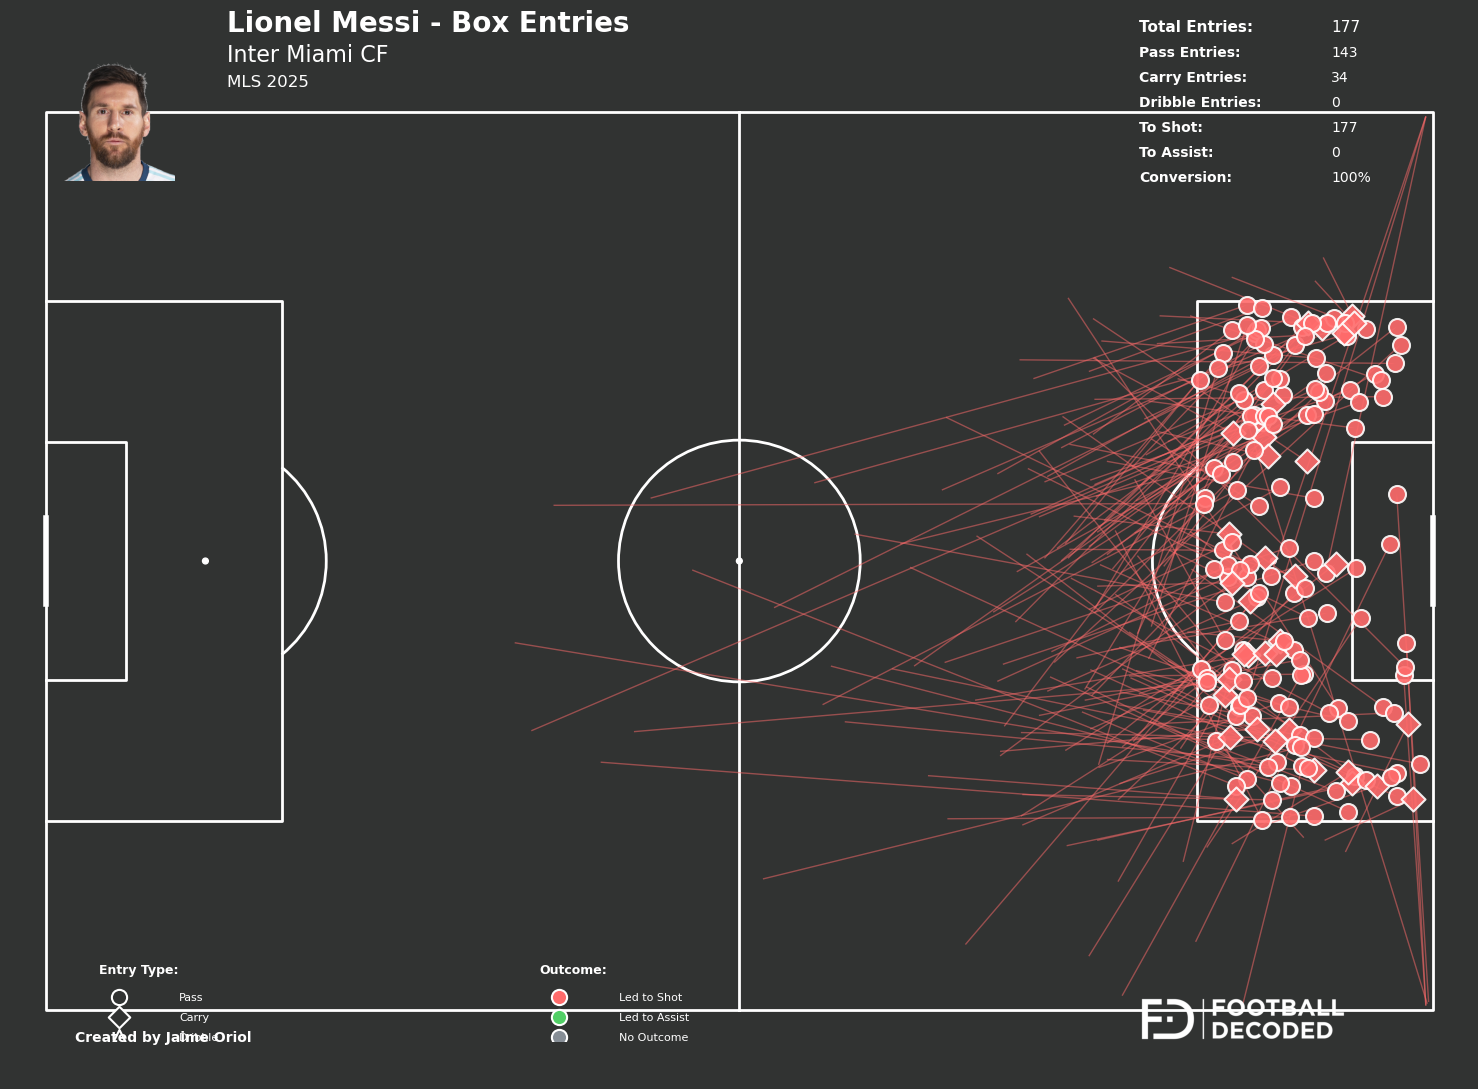

In [18]:
# Viz 7: Box Entries
fig7 = plot_box_entries(
    csv_path='./outputs/messi_box_entries.csv',
    player_name='Lionel Messi',
    face_path='../caras/extras/messi.png',
    team_name='Inter Miami CF',
    competition='MLS',
    season='2025',
    save_path='./outputs/plots/07_box_entries.png'
)
print("Viz 7: Box Entries - Guardado")